---
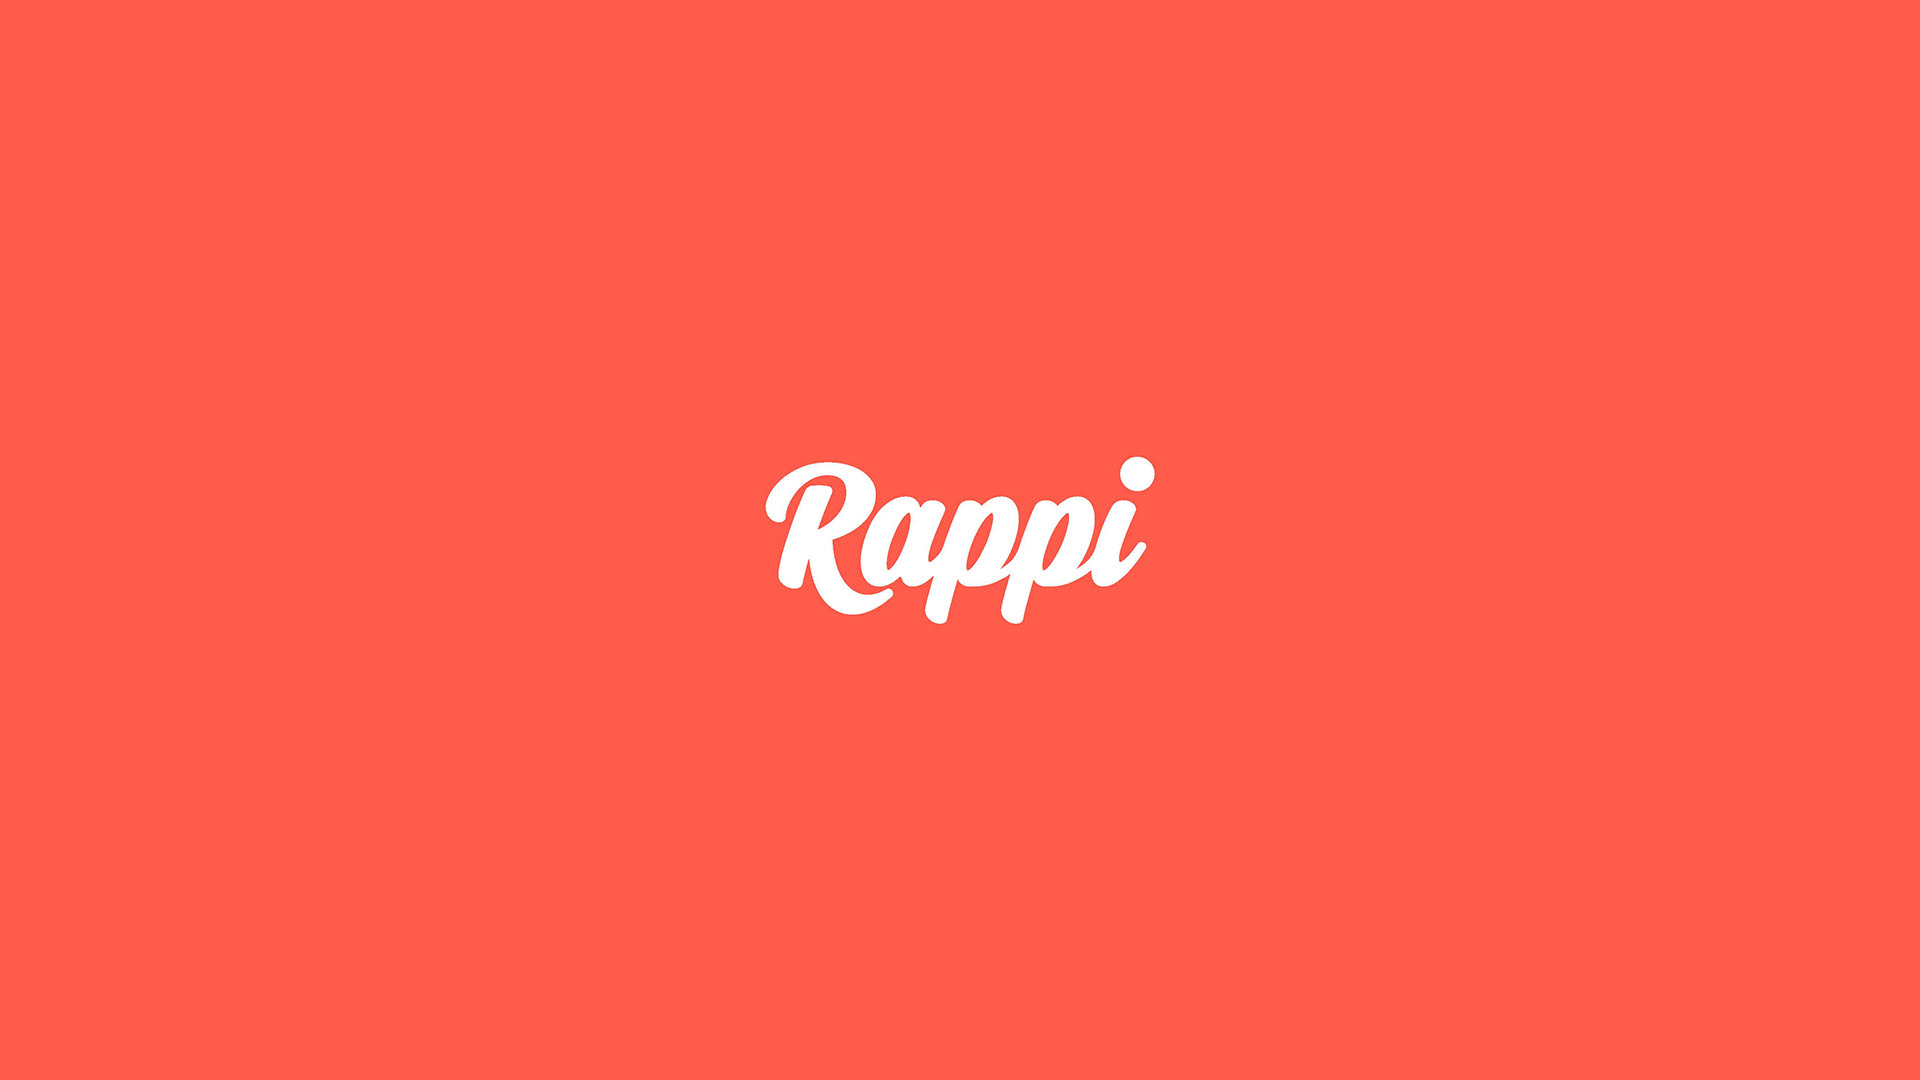


---




#**Instalações**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import date
from datetime import datetime
import seaborn as sns; sns.set();
import plotly.express as px;
import pyarrow.feather as feather

In [ ]:
df_contas_churn = pd.read_csv("/content/drive/Shareddrives/Bases Compartilhadas/Cópia de Cópia de criacao contas churn-002.csv")
df_infos_gerais = pd.read_csv("/content/drive/Shareddrives/Bases Compartilhadas/Cópia de Cópia de infos gerais.csv")
df_incidentes = pd.read_csv("/content/drive/Shareddrives/Bases Compartilhadas/Cópia de Cópia de Incidentes_Regras RT.csv")
df_defects = pd.read_csv("/content/drive/Shareddrives/Bases Compartilhadas/Cópia de Cópia de comp defects.csv")
df_ordens = pd.read_csv("/content/drive/Shareddrives/Bases Compartilhadas/Cópia de Cópia de Ordens Done e Cancel.csv")
df_rate = pd.read_csv("/content/drive/Shareddrives/Bases Compartilhadas/Cópia de Cópia de attendance rate.csv")
df_earnings = pd.read_csv("/content/drive/Shareddrives/Bases Compartilhadas/Cópia de Cópia de earnings.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# não é necessário rodar 
df_product = pd.read_csv("/content/drive/Shareddrives/Bases Compartilhadas/Cópia de Cópia de Product return.csv")
df_supply = pd.read_csv("/content/drive/Shareddrives/Bases Compartilhadas/Cópia de Cópia de supply.csv")
df_tempo_resolucao = pd.read_csv("/content/drive/Shareddrives/Bases Compartilhadas/Cópia de Cópia de tempo resolutcao e modal-001.csv")

#DataFrame Principal

In [ ]:
#Inserindo nova coluna no dataframe de churns

df_contas_churn.insert(1, "Churn(sim=1/não=0)", 1) 
df_infos_gerais.insert(1, "Churn(sim=1/não=0)", 0)


churn_data = df_contas_churn[['ID', 'Churn(sim=1/não=0)']]
nchurn_data = df_infos_gerais[['ID', 'Churn(sim=1/não=0)']]

df_all_storekeepers = churn_data.merge(nchurn_data, how='right', left_on='ID', right_on='ID')[['ID','Churn(sim=1/não=0)_x']].fillna(0)
df_all_store = df_all_storekeepers[['ID', 'Churn(sim=1/não=0)_x']].drop_duplicates()

In [ ]:
df_all_store.to_csv('/content/drive/Shareddrives/Bases Compartilhadas/Features/all_storekeepers.csv', index=False)

# Feature 1 - Quantitativo de punições 

- A feature abaixo partiu da hipótese de que entregadores com maior número de punições tem maiores chances de dar churn.

- A Planilha utilizada no estudo foi a "df_incidentes" e as colunas foram "STOREKEEPER_ID" e "PUNISHMENT_TYPE"

In [ ]:
df_warning = df_incidentes[['STOREKEEPER_ID', 'PUNISHMENT_TYPE']].groupby(by=['STOREKEEPER_ID']).count()
df_warning_punishment = df_warning.merge(df_all_store, how='right', left_on='STOREKEEPER_ID', right_on='ID')
df_warning_punishment.rename(columns = {'PUNISHMENT_TYPE':'Quantidade Punições'}, inplace = True)
df_warning_punishment['Quantidade Punições'] = df_warning_punishment['Quantidade Punições'].fillna(0)
df_warning_punishment.to_csv('/content/drive/Shareddrives/Bases Compartilhadas/Features/punishment_quantitative.csv', index=False)

#Feature 2 - Quantitativo de Churns 

- A feature abaixo partiu da hipótese de que um entregador que deu churn uma vez tem maiores chances de dar churn novamente
- A planilha utilizada no estudo foi a "df_contas_churn" e as colunas utilizadas foram "ID" e "Count"

In [ ]:
count_churns = df_contas_churn.assign(Count=1)
count_all_churns = count_churns[['ID', 'Count']].groupby(by = 'ID').sum()
df_qtd_churns = df_all_store.merge(count_all_churns, how='left', left_on='ID', right_on='ID')
df_qtd_churns['Count'] = df_qtd_churns['Count'].fillna(0) # Substituir nan por zero
df_qtd_churns.to_csv('/content/drive/Shareddrives/Bases Compartilhadas/Features/churns_quantitative.csv', index=False)

#Feature 3 - Modal

- A feature abaixo partiu da hipótese de que, devido o uso de certos modais, existe maior probabilidade dos entregadores darem churn, por conta da amplitude de entregas e consequentemente de ganhos.
- A planilha utilizada foi a "df_infos_gerais" e as colunas foram "ID" e "TRANSPORTE"

In [ ]:
df_infos = df_infos_gerais[['ID', 'TRANSPORTE']].merge(df_all_store, how='inner', left_on='ID', right_on='ID')
df_infos[df_infos ['Churn(sim=1/não=0)_x'] == 1].groupby(by=['TRANSPORTE']).sum().drop(columns=['ID'])

# Feature 4 - Taxa de entregas canceladas 

- A feature abaixo partiu da hipótese de que entregadores com altas taxas de cancelamento dos pedidos, tem maior propensão a darem churn.
- A planilha utilizada foi a "df_ordens" e as colunas foram "ORDERS_CANCEL", "CANCEL_OPS_RT", "STOREKEEPER_ID" e "ORDERS_DONE"

In [ ]:
# Taxa de cancelamento total
df_cancel_orders = df_ordens.eval( 'Taxa = (ORDERS_CANCEL + CANCELS_OPS_RT)/(ORDERS_DONE + ORDERS_CANCEL + CANCELS_OPS_RT) ')[['STOREKEEPER_ID', 'Taxa']]
df_cancel_tax = df_cancel_orders.merge(df_all_store, how='inner', left_on='STOREKEEPER_ID', right_on='ID').drop(columns = ['ID'])
df_cancel_tax.to_csv('/content/drive/Shareddrives/Bases Compartilhadas/Features/storekeeper_cancel_tax.csv', index=False)

#Feature 5 - Taxa de aceitação do pedido

- A feature abaixo partiu da hipótese de que entregadores com uma taxa de aceitação baixa possuem uma maior propensão a dar churn
- A planilha utilizada foi a "df_rate" e as colunas foram "STOREKEEPER_ID" e "ACCEPTANCE_RATE"

In [ ]:
df_rate_na = df_rate.merge(df_all_store, how='inner', left_on='STOREKEEPER_ID', right_on='ID').drop(columns = ['ID'])
df_rate_na['ACCEPTANCE_RATE'] = df_rate_na['ACCEPTANCE_RATE'].fillna(0)
df_rate_na.to_csv('/content/drive/Shareddrives/Bases Compartilhadas/Features/acceptance_tax.csv', index=False)

# Feature 6 - Auto-aceite

- A feature abaixo partiu da hipótese de que entregadores com o auto-aceite desativado também entregam em outras plataformas e possuem maiores chances de dar churn
- A planilha utilizada foi a "df_infos_gerais" e as colunas foram "ID" e "AUTO_ACEITE"

In [ ]:
df_auto_aceite = df_infos_gerais[['ID', 'AUTO_ACEITE']]
df_auto_accept = df_auto_aceite.merge(df_all_store, how='inner', left_on='ID', right_on='ID')
df_auto_accept.to_csv('/content/drive/Shareddrives/Bases Compartilhadas/Features/auto_accept.csv', index=False)
# Entregadores que nao possuem auto-aceite podem ter outras fontes e maiores chances de dar churn 

# Feature 7 - Earnings por categoria

- A feature abaixo partiu da hipótese de que entregadores com ganhos abaixo da média de sua categoria tem uma maior propensão a dar churn 
- As planilhas utilizadas foram "df_earnings", "df_levels" e "df_defects" e as colunas foram "STOREKEEPER_ID", "LEVEL_NAME" e "EARNINGS" 

In [ ]:
# Ganho médio de cada categoria 
categories = ['bronze', 'danger', 'diamond', 'rookie', 'silver']

b = df_earnings.drop(columns = ['MONTH'])
df_levels = df_defects[['STOREKEEPER_ID', 'LEVEL_NAME']].drop_duplicates()
df_levels_earnings = df_levels.merge(b, how='inner', left_on='STOREKEEPER_ID', right_on='STOREKEEPER_ID')
df_level_earnings = df_levels_earnings.drop(columns = ['STOREKEEPER_ID', 'TIPS']).groupby(by = ['LEVEL_NAME']).mean()
df_level_earnings.assign(LEVEL_NAME=categories)


# Ganhos médios por entregador
df_category = df_defects[['STOREKEEPER_ID', 'LEVEL_NAME']].drop_duplicates()
earning_each = df_earnings[['STOREKEEPER_ID', 'EARNINGS']].groupby(by=['STOREKEEPER_ID']).mean()
df_earning_level = earning_each.merge(df_category, how='inner', left_on='STOREKEEPER_ID', right_on='STOREKEEPER_ID')


# Merge
df_earning_categories = df_earning_level.merge(df_level_earnings, how='inner', left_on='LEVEL_NAME', right_on='LEVEL_NAME')
df_earnings_categories = df_earning_categories.rename(columns={'EARNINGS_y': 'EARNINGS CAT.', 'EARNINGS_x': 'EARNINGS STO.'})
df_all_store_cat = df_all_store.merge(df_earnings_categories, how='inner', left_on='ID', right_on='STOREKEEPER_ID').drop(columns='STOREKEEPER_ID')
df_all_store_cat.assign(Earning_Cat = 0)


In [ ]:
for i in range(len(df_all_store_cat)):
  if df_all_store_cat['EARNINGS STO.'][i] >= df_all_store_cat['EARNINGS CAT.'][i]:
    df_all_store_cat.loc[i, 'Earning_Cat'] = 1

df_all_store_cat = df_all_store_cat.fillna(0)

In [ ]:
df_all_store_cat[['ID', 'Churn(sim=1/não=0)_x', 'LEVEL_NAME', 'Earning_Cat']].to_csv('/content/drive/Shareddrives/Bases Compartilhadas/Features/storekeeper_category.csv', index=False)

# 8 - Earnings por modal (Classificação)


In [ ]:
# Ganho médio por modal

modais = ['bicycle', 'car', 'cargo_van', 'motorbike', 'motorbike_trailer', 'neither']
earnings_modal = df_infos_gerais.merge(df_earnings, how='inner', left_on='ID', right_on='STOREKEEPER_ID')[['TRANSPORTE', 'EARNINGS']].groupby(by=['TRANSPORTE']).mean()
earnings_modal.assign(LEVEL_NAME = modais)

# Ganho médio por entregador

df_modal = df_infos_gerais[['ID', 'TRANSPORTE']].drop_duplicates()
earning_each = df_earnings[['STOREKEEPER_ID', 'EARNINGS']].groupby(by=['STOREKEEPER_ID']).mean()
df_earning_level = earning_each.merge(df_modal, how='inner', left_on='STOREKEEPER_ID', right_on='ID')


# Merge 

df_all_store_modal = df_earning_level.merge(earnings_modal, how='inner', left_on='TRANSPORTE', right_on='TRANSPORTE')
df_all_store_mod = df_all_store_modal.merge(df_all_store, how='inner', left_on='ID', right_on='ID')
df_all_store_mod.assign(Media_Modal_sim1_não0 = 0)



In [ ]:
for i in range(len(df_all_store_mod)):
  if df_all_store_mod['EARNINGS_x'][i] >= df_all_store_mod['EARNINGS_y'][i]:
    df_all_store_mod.loc[i, 'Media_Modal_sim1_não0'] = 1 


df_all_store_mod = df_all_store_mod.fillna(0)

In [ ]:
df_all_store_mod[['ID', 'TRANSPORTE', 'Churn(sim=1/não=0)_x', 'Media_Modal_sim1_não0']].to_csv('/content/drive/Shareddrives/Bases Compartilhadas/Features/media_modal.csv', index=False)

# 9 - Quantitativo de defects (média semanal)

- A feature abaixo partiu da hipótese de que entregadores que possuem muitas entregas com defeito tem maior propensão a dar churn por ser algo que prejudica os entregadores
- A planilha utilizada foi a df_defects e as colunas foram "STOREKEEPER_ID" e "ORDERS"
- Feature 4

In [ ]:
# Quantitativo de ordens com defeito (media semanal)
count_defects = df_defects.assign(Count=1)
count_defect = count_defects[['STOREKEEPER_ID', 'ORDERS']].groupby(by = 'STOREKEEPER_ID').mean()
count_defect_na = count_defect.merge(df_all_store, how='right', left_on='STOREKEEPER_ID', right_on='ID') #Substituir nan por zero
count_defect_na['ORDERS'] = count_defect_na['ORDERS'].fillna(0)
count_defect_na.to_csv('/content/drive/Shareddrives/Bases Compartilhadas/Features/defects_mean.csv', index=False)